In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')


def mean_absolute_percentage_error(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model_name, model, X, y):
    
    predictions = model.predict(X)

    MAE = mean_absolute_error(y, predictions)
    MAPE = mean_absolute_percentage_error(y, predictions)
    RMSE = mean_squared_error(y, predictions, squared = False)
    R2 = r2_score(y, predictions)

    print('MAE for', model_name, ': %1.3f' % MAE)
    print('MAPE for', model_name, ': %1.3f' % MAPE)
    print('RMSE for', model_name, ': %1.3f' % RMSE)
    print('R2 for', model_name, ': %1.3f' % R2)
    
    
def plot_predictions(model, x, y, title):
    
    plt.figure(figsize = (7, 4))
    sns.scatterplot(x = y, y = model.predict(x), s = 20)
    sns.lineplot([0, y.max()], [0, y.max()], color = 'black', linewidth = 1)
    plt.title(title + '\n')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()

In [2]:
city = 'barcelona'

listings_link = 'data/' + city + '/listings_modeling.csv'
listings = pd.read_csv(listings_link)

Train test split

In [3]:
y = listings['price']
X = listings.drop('price', 1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20202020, train_size = 0.8)

Categorical features - gmbs can handle them without one hot encoding

In [4]:
categorical_features = X.select_dtypes(include = 'O').columns.tolist()
print(categorical_features)

['host_response_time', 'room_type', 'neighbourhood_cleansed_grouped']


## 1. Baseline default CatBoost

In [5]:
default_model = CatBoostRegressor(random_state = 20202020, 
                                  learning_rate = 0.03,
                                  iterations = 1000,
                                  # early_stopping_rounds = 15,
                                  cat_features = categorical_features,
                                  one_hot_max_size = 20,
                                  verbose = 100)
default_model.fit(X_train, y_train, plot = True, verbose = False)# eval_set = (X_test, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [6]:
evaluate_model('Default CatBoost on train', default_model, X_train, y_train)

MAE for Default CatBoost on train : 24.540
MAPE for Default CatBoost on train : 34.515
RMSE for Default CatBoost on train : 38.224
R2 for Default CatBoost on train : 0.792


In [7]:
evaluate_model('Default CatBoost on test', default_model, X_test, y_test)

MAE for Default CatBoost on test : 30.633
MAPE for Default CatBoost on test : 41.354
RMSE for Default CatBoost on test : 50.831
R2 for Default CatBoost on test : 0.628


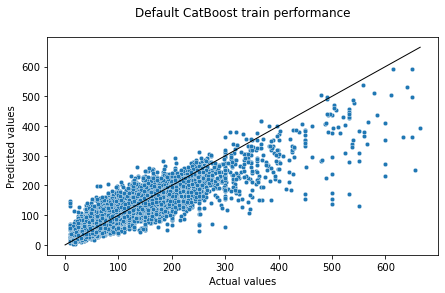

In [8]:
plot_predictions(default_model, X_train, y_train, 'Default CatBoost train performance')

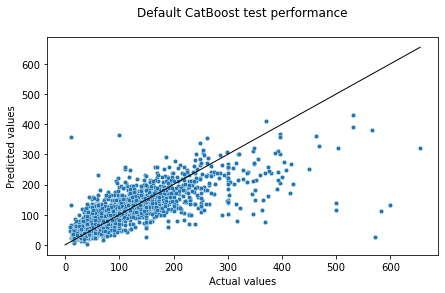

In [9]:
plot_predictions(default_model, X_test, y_test, 'Default CatBoost test performance')

In [10]:
tree_num = default_model._tree_count

if tree_num != default_model.get_all_params()['iterations']:
    
    default_model = CatBoostRegressor(random_state = 20202020, 
                                  learning_rate = 0.03,
                                  iterations = tree_num,
                                  cat_features = categorical_features,
                                  one_hot_max_size = 20,
                                  verbose = 100)
    default_model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = False)

### SHAP & feature statistics

In [11]:
from catboost import Pool
import shap
shap.initjs()

In [12]:
train_pool = Pool(X_train, y_train, 
                  cat_features = categorical_features)

test_pool = Pool(X_test, y_test, 
                  cat_features = categorical_features)

In [13]:
default_model.calc_feature_statistics(train_pool)

{'host_response_time': {'binarized_feature': array([1, 4, 1, ..., 4, 1, 3]),
  'mean_target': array([ 61.231842, 116.79522 ,  67.25541 ,  99.27956 , 108.52325 ],
        dtype=float32),
  'mean_weighted_target': array([], dtype=float32),
  'mean_prediction': array([ 62.885983, 116.88986 ,  66.72977 ,  98.67853 , 108.82995 ],
        dtype=float32),
  'objects_per_bin': array([ 358, 4019, 2126,  905, 1183], dtype=uint32),
  'predictions_on_varying_feature': array([ 97.37638749,  99.45969388, 100.86385591, 101.73365316,
          99.62100307]),
  'cat_values': array(['few_days', 'within_hour', 'missing', 'within_day',
         'within_few_hours'], dtype='<U16')},
 'host_response_rate': {'borders': array([-3.40282347e+38,  5.00000007e-02,  1.14999995e-01,  1.59999996e-01,
          2.04999998e-01,  2.15000004e-01,  3.89999986e-01,  4.09999996e-01,
          4.25000012e-01,  5.34999967e-01,  5.95000029e-01,  6.05000019e-01,
          6.75000012e-01,  6.89999998e-01,  7.95000017e-01,  8.050

In [14]:
shap_values = default_model.get_feature_importance(train_pool, type = 'ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [15]:
print('Predicted value:', default_model.predict(X_train)[10])
print('Actual value:', y_train.iloc[10])

Predicted value: 132.71334983048774
Actual value: 125.0


In [16]:
shap.force_plot(expected_value, shap_values[10,:], X_train.iloc[10,:])

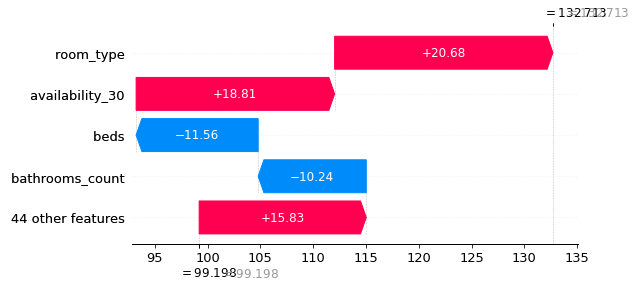

In [17]:
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[10], X_train.iloc[10,:], max_display = 5)

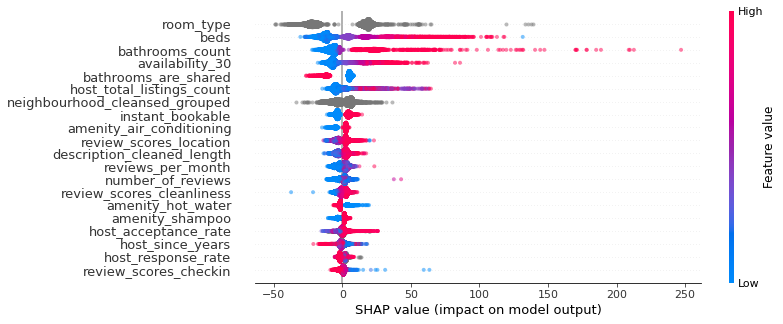

In [18]:
shap.summary_plot(shap_values, X_train, plot_type = 'dot', plot_size = (10, 5), alpha = 1/2)

In [20]:
# for name in X_test.columns.tolist(): #[i for i in X_test.columns.tolist() if i not in categorical_features]:
#     shap.dependence_plot(name, shap_values, X_train, dot_size = 20, alpha = 1/2)